In [1]:
import os
import copy

import torch
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from openTSNE import TSNE

import matplotlib
import matplotlib.pyplot as plt

from src.utils import load_pickle_obj
from src.relative_embedding import DescriptorColors
from src.graph import description_graph

In [2]:
def plot_relative_embeddings(model_embeddings, 
                             target_embedding, 
                             colored_descriptions, 
                             colors,
                             dimension_reduction = 'tsne',
                             tsne_perplexity = 30.,
                             tsne_seed = 42,
                             filename = None):
    
    assert dimension_reduction in ['pca', 'tsne']
    if filename is not None:
        assert isinstance(filename, str)
    
    colors = copy.deepcopy(colors)
    colors['black'] = (0, 0, 0)
    for color in colors:
        colors[color] =  tuple([value / 255 for value in colors[color]])
    
    
    all_descritpions = []
    for color in colored_descriptions:
        all_descritpions += colored_descriptions[color]
        
    embeddings = {}
    for des_name in all_descritpions:
        for idx in model_embeddings:
            if des_name == model_embeddings[idx]['description']:
                embeddings[des_name] = model_embeddings[idx][target_embedding]
                break
                
    assert len(embeddings) == len(all_descritpions)
    data_matrix, groups = [], []
    for des_name in embeddings:
        detect_color = 'black'
        data_matrix.append(embeddings[des_name])
        for color in colored_descriptions:
            if des_name in colored_descriptions[color]:
                detect_color = color
                break
                
        groups.append(detect_color)
        
    data_matrix = torch.stack(data_matrix).numpy()
    if dimension_reduction == 'pca':
        pca = PCA(n_components = 2)
        components = pca.fit_transform(data_matrix)
    elif dimension_reduction == 'tsne':    
        tsne = TSNE(n_components = 2,
                    initialization = 'pca',
                    perplexity = tsne_perplexity, 
                    random_state = tsne_seed)
        
        components = tsne.fit(data_matrix)
    
    df = pd.DataFrame(data = components, columns = ['Dim1', 'Dim2'])
    df['Group'] = groups
    
    plt.figure(figsize=(10, 10))
    unique_groups = df['Group'].unique()
    
    for group in unique_groups:
        indices = df['Group'] == group
        plt.scatter(df.loc[indices, 'Dim1'], 
                    df.loc[indices, 'Dim2'], 
                    c = [colors[group]], 
                    edgecolor = None, 
                    s = 100)
        
    if dimension_reduction == 'pca':
        plt.xlabel('PCA Dim 1')
        plt.ylabel('PCA Dim 2')
        plt.title('PCA of LLM embeddings')
    elif dimension_reduction == 'tsne':
        plt.xlabel('t-SNE Dim 1')
        plt.ylabel('t-SNE Dim 2')
        plt.title('t-SNE of LLM embeddings')
    
    if filename is not None:
        if not filename.endswith('.png'):
            filename += '.png'
            
        plt.savefig(filename, 
                    dpi = 300, 
                    bbox_inches = 'tight')
        print('Save as file: {0} successfully.'.format(filename))
    else:
        plt.show()
    
    return None

In [3]:
graph = description_graph()

In [4]:
def concat_folder(file_dict, folder):
    for ftype in file_dict:
        file_dict[ftype] = os.path.join(folder, file_dict[ftype])
        
    return file_dict

def load_embeddings(file_dict):
    embeddings = {}
    for embedding_type in file_dict:
        if os.path.isfile(file_dict[embedding_type]):
            embeddings[embedding_type] = load_pickle_obj(file_dict[embedding_type])
        else:
            embeddings[embedding_type] = None
            
    return embeddings

folder_name = './outputs'
albert_files = {'pretrained': 'pretrained-ALBERT_embeddings.pkl',
                'finetuned': 'finetuned-ALBERT-N5kE3_embeddings.pkl'}
bart_files = {'pretrained': 'pretrained-BART_embeddings.pkl',
              'finetuned': 'finetuned-BART-N10kE3_embeddings.pkl'}
bert_files = {'pretrained': 'pretrained-BERT_embeddings.pkl',
              'finetuned': 'finetuned-BERT-N20kE3_embeddings.pkl'}
gpt_files = {'pretrained': 'pretrained-GPT2_embeddings.pkl',
             'finetuned': 'finetuned-GPT2-N100kE8_embeddings.pkl'}
roberta_files = {'pretrained': 'pretrained-RoBERTa_embeddings.pkl',
                 'finetuned': 'finetuned-RoBERTa-N100kE1_embeddings.pkl'}
t5_files = {'pretrained': 'pretrained-T5_embeddings.pkl',
            'finetuned': 'finetuned-T5-N100kE8_embeddings.pkl'}

gemma2_files = {'pretrained': 'pretrained-Gemma2_embeddings.pkl'}
llama3_files = {'pretrained': 'pretrained-Llama3_embeddings.pkl'}
qwen2_files = {'pretrained': 'pretrained-Qwen2_embeddings.pkl'}

albert_files = concat_folder(albert_files, folder_name)
bart_files = concat_folder(bart_files, folder_name)
bert_files = concat_folder(bert_files, folder_name)
gpt_files = concat_folder(gpt_files, folder_name)
roberta_files = concat_folder(roberta_files, folder_name)
t5_files = concat_folder(t5_files, folder_name)

gemma2_files = concat_folder(gemma2_files, folder_name)
llama3_files = concat_folder(llama3_files, folder_name)
qwen2_files = concat_folder(qwen2_files, folder_name)

albert_embeddings = load_embeddings(albert_files)
bart_embeddings = load_embeddings(bart_files)
bert_embeddings = load_embeddings(bert_files)
gpt_embeddings = load_embeddings(gpt_files)
roberta_embeddings = load_embeddings(roberta_files)
t5_embeddings = load_embeddings(t5_files)

gemma2_embeddings = load_embeddings(gemma2_files)
llama3_embeddings = load_embeddings(llama3_files)
qwen2_embeddings = load_embeddings(qwen2_files)

In [5]:
colored_descriptions = {}

for descritpion in graph.descriptions:
    for color in DescriptorColors:
        if graph.distance_between_descriptions(descritpion, color) < 10.:
            if color not in colored_descriptions.keys():
                colored_descriptions[color] = [descritpion]
            else:
                colored_descriptions[color].append(descritpion)  
                
for color in colored_descriptions:
    colored_descriptions[color] = list(set(colored_descriptions[color]))

Save as file: Pretrained_ALBERT.png successfully.


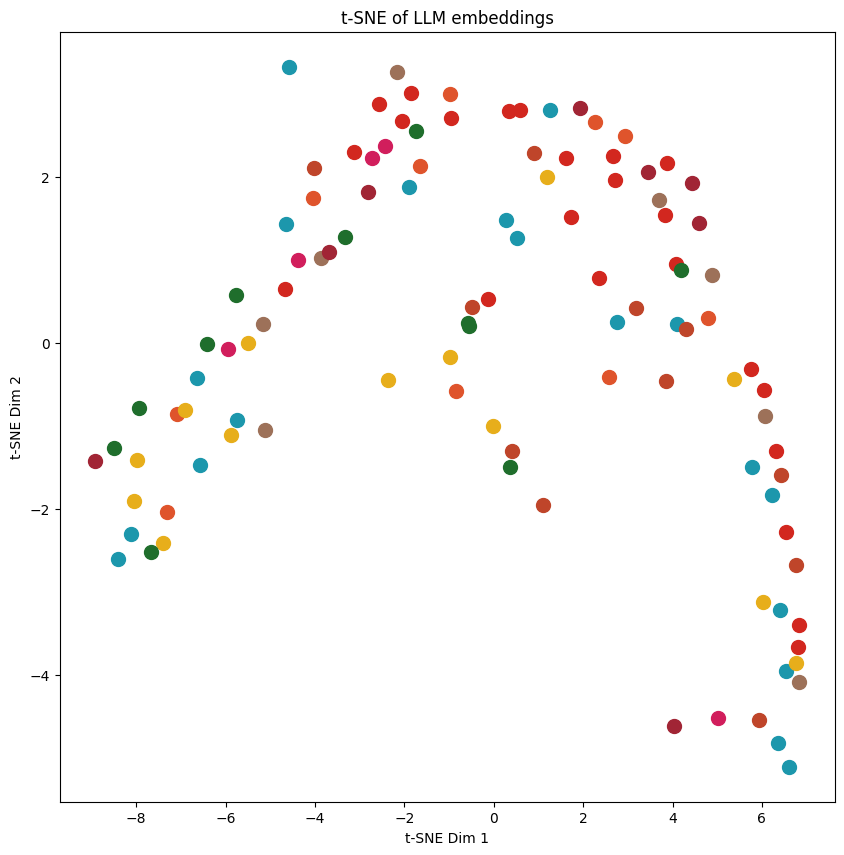

In [6]:
# pretained ALBERT
if albert_embeddings['pretrained'] is not None:
    plot_relative_embeddings(albert_embeddings['pretrained'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Pretrained_ALBERT')

Save as file: Finetuned_ALBERT.png successfully.


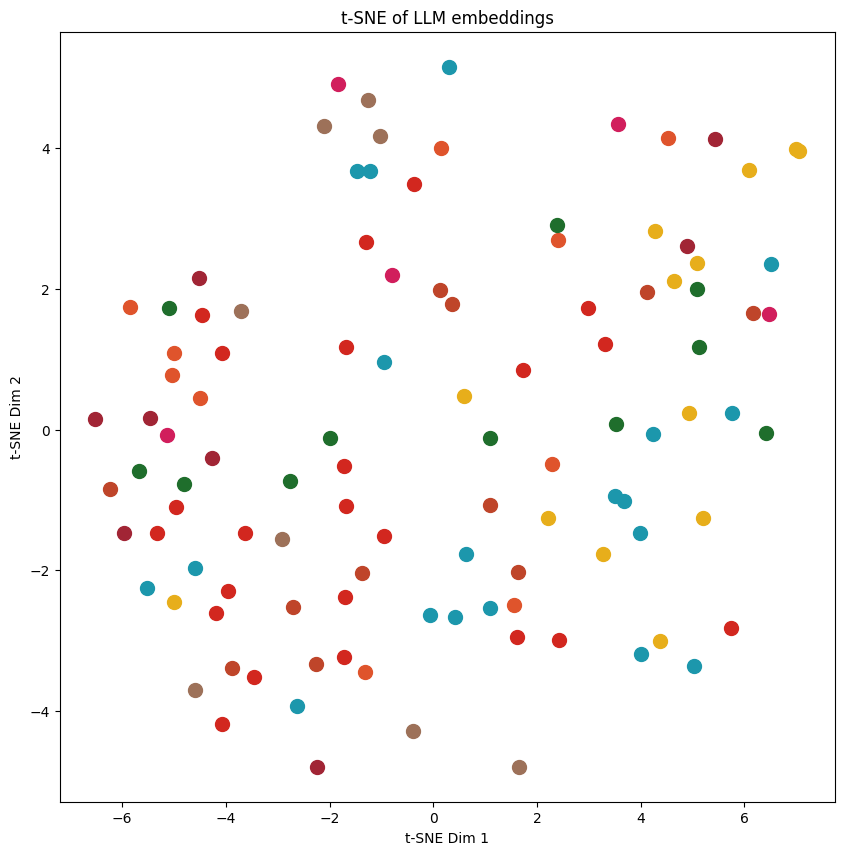

In [7]:
# finetuned ALBERT
if albert_embeddings['finetuned'] is not None:
    plot_relative_embeddings(albert_embeddings['finetuned'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Finetuned_ALBERT')

Save as file: Pretrained_BART_enc.png successfully.


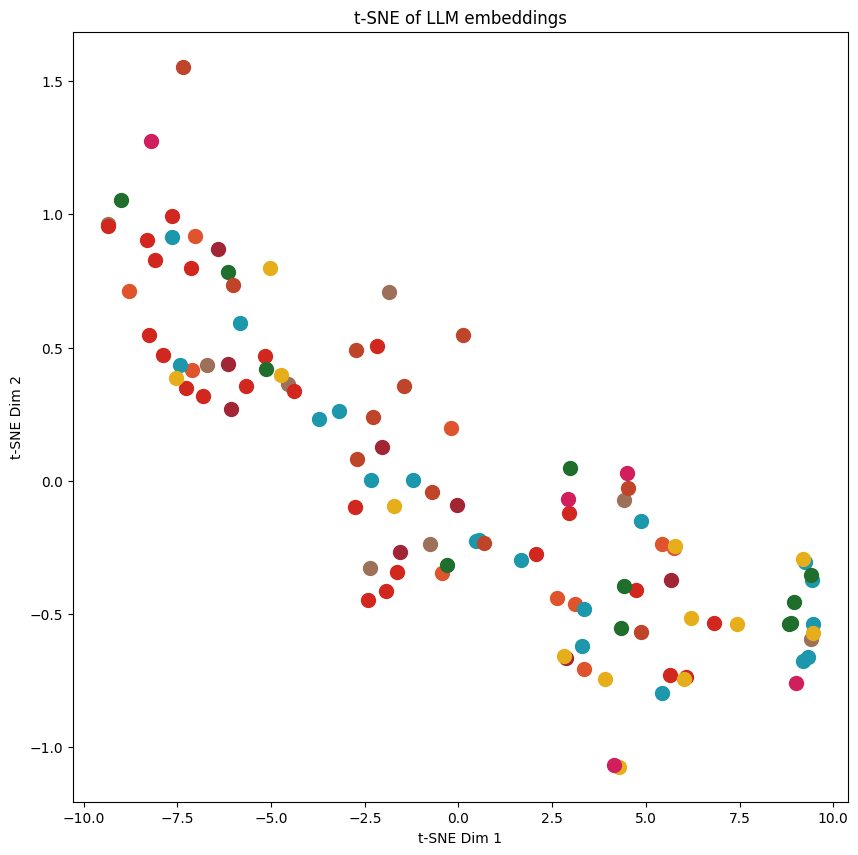

In [8]:
# pretained BART encoder
if bart_embeddings['pretrained'] is not None:
    plot_relative_embeddings(bart_embeddings['pretrained'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Pretrained_BART_enc')

Save as file: Finetuned_BART_enc.png successfully.


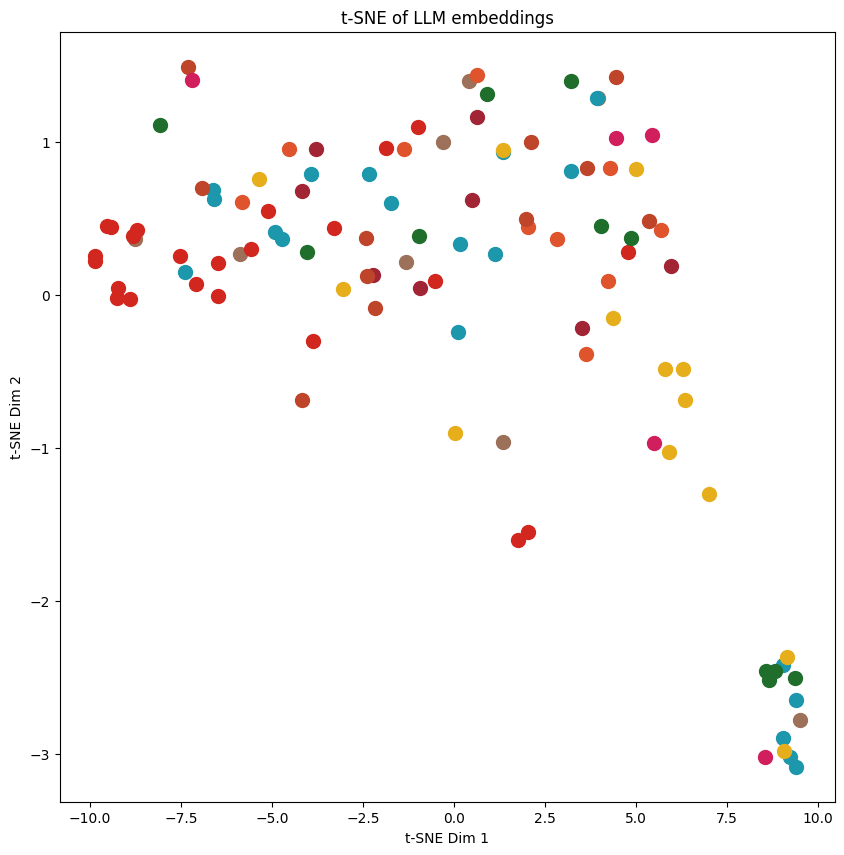

In [9]:
# finetuned BART encoder
if bart_embeddings['finetuned'] is not None:
    plot_relative_embeddings(bart_embeddings['finetuned'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Finetuned_BART_enc')

Save as file: Pretrained_BART_dec.png successfully.


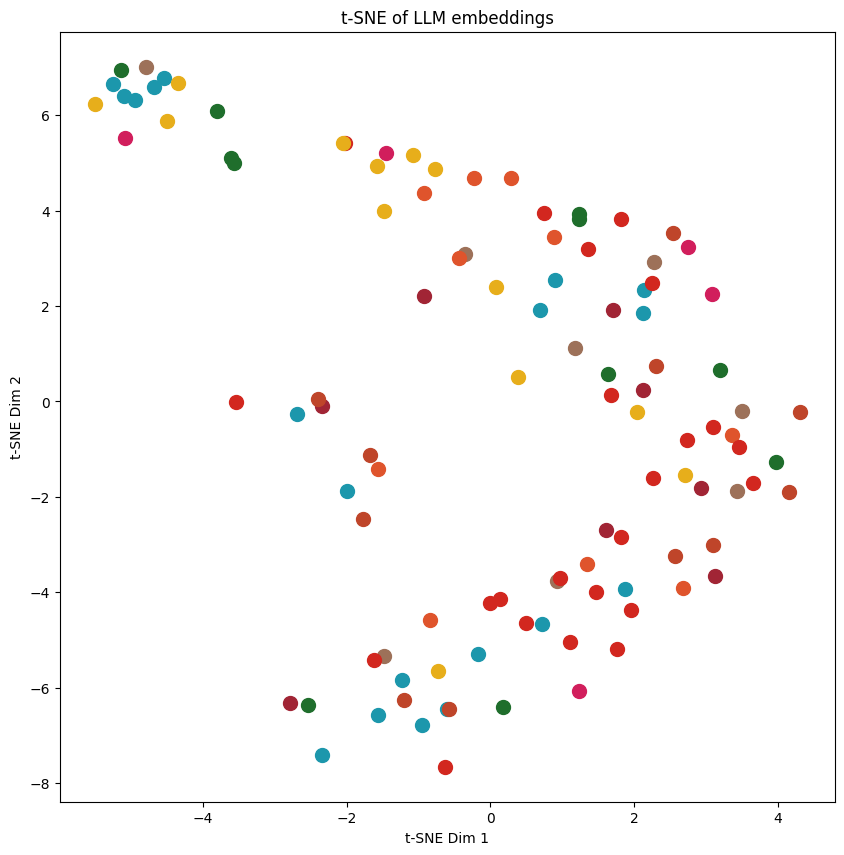

In [10]:
# pretained BART decoder
if bart_embeddings['pretrained'] is not None:
    plot_relative_embeddings(bart_embeddings['pretrained'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Pretrained_BART_dec')

Save as file: Finetuned_BART_dec.png successfully.


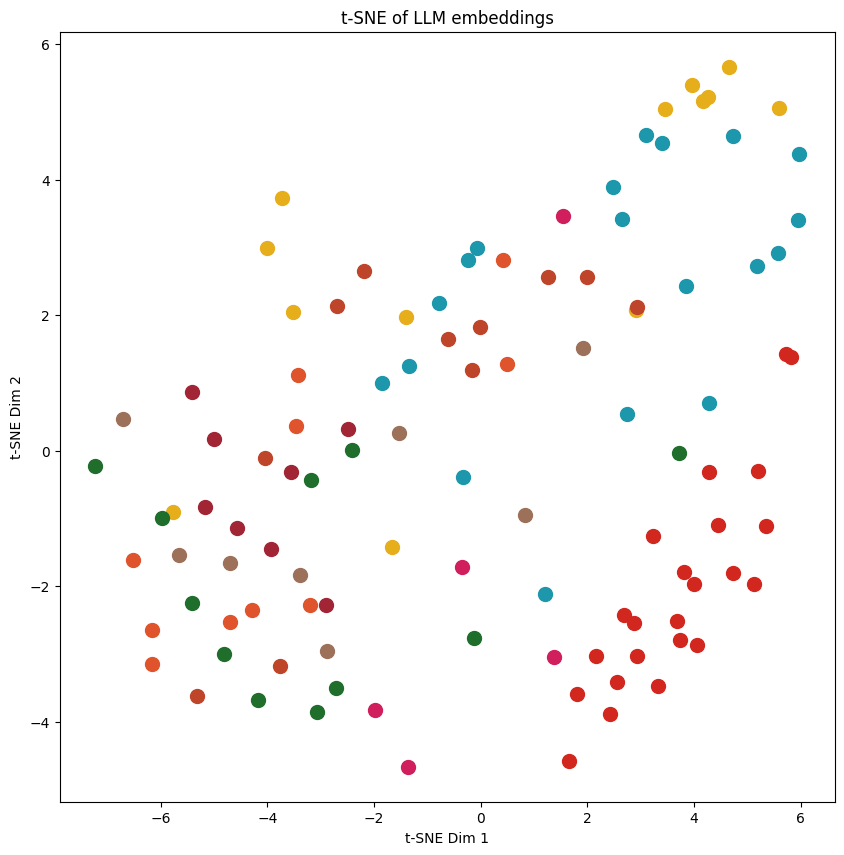

In [11]:
# finetuned BART decoder
if bart_embeddings['finetuned'] is not None:
    plot_relative_embeddings(bart_embeddings['finetuned'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Finetuned_BART_dec')

Save as file: Pretrained_BERT.png successfully.


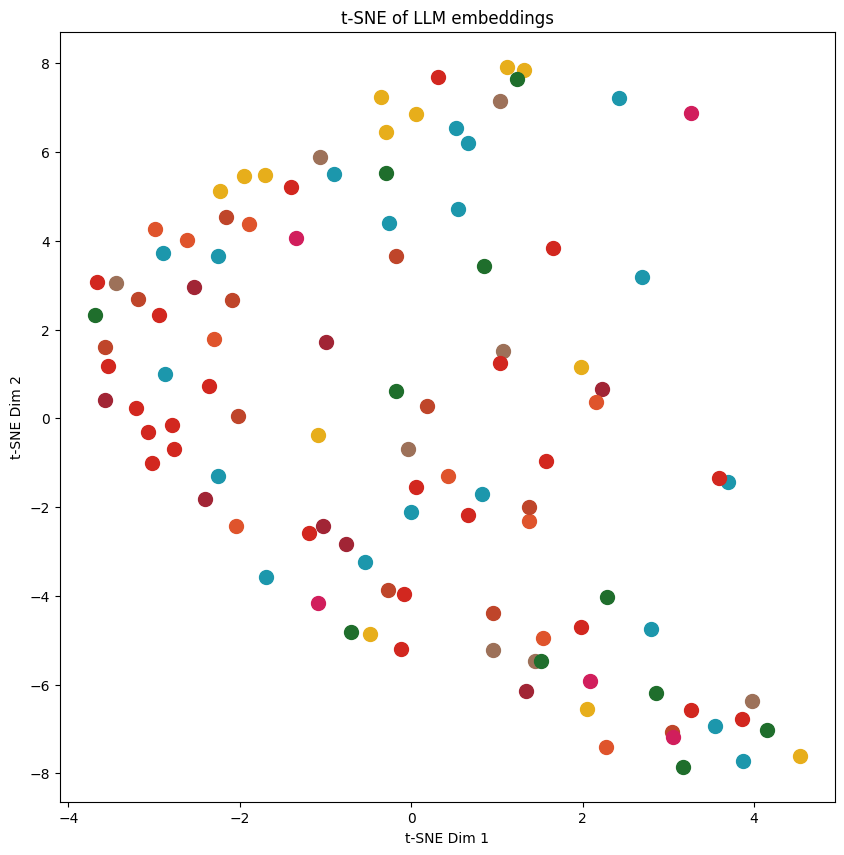

In [12]:
# pretained BERT
if bert_embeddings['pretrained'] is not None:
    plot_relative_embeddings(bert_embeddings['pretrained'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Pretrained_BERT')

Save as file: Finetuned_BERT.png successfully.


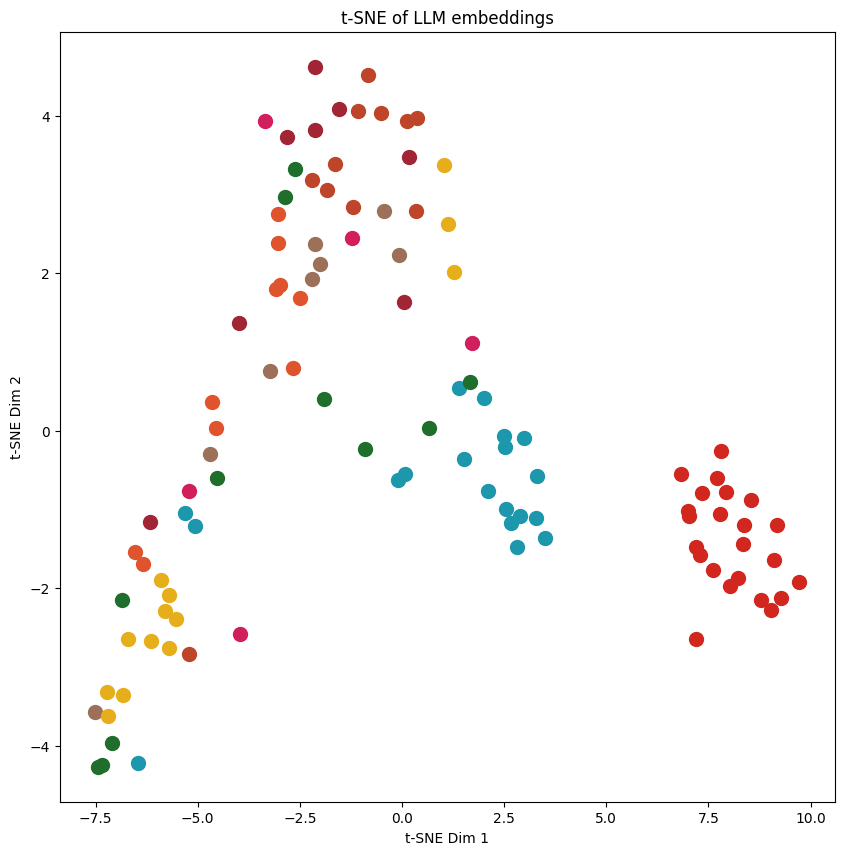

In [13]:
# finetuned BERT
if bert_embeddings['finetuned'] is not None:
    plot_relative_embeddings(bert_embeddings['finetuned'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Finetuned_BERT')

Save as file: Pretrained_GPT.png successfully.


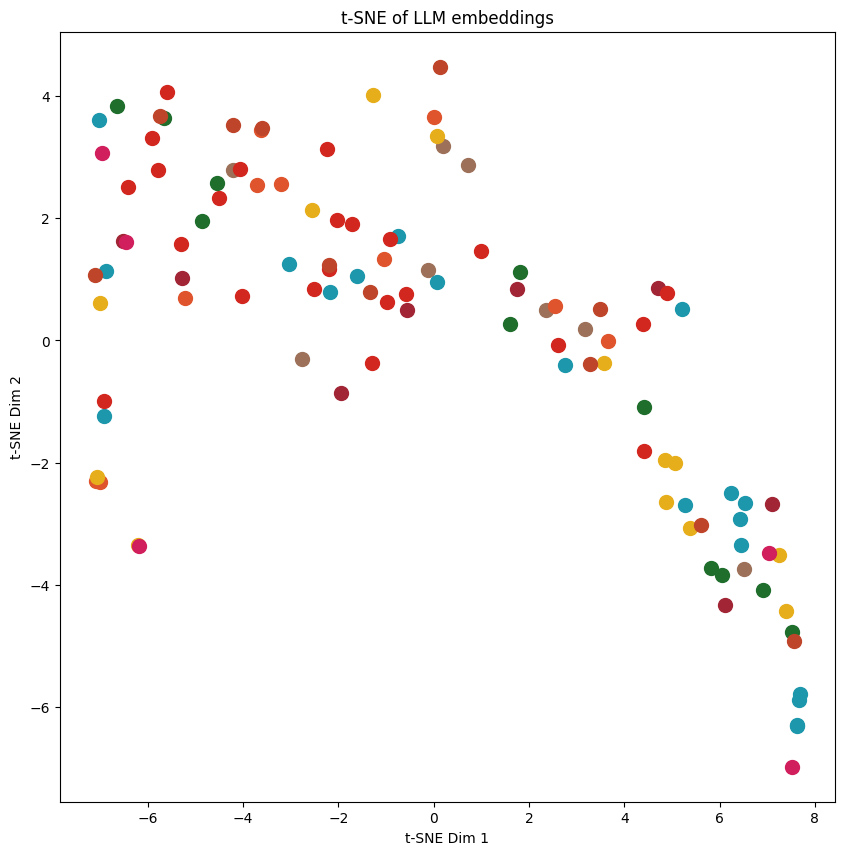

In [14]:
# pretained GPT
if gpt_embeddings['pretrained'] is not None:
    plot_relative_embeddings(gpt_embeddings['pretrained'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Pretrained_GPT')

Save as file: Finetuned_GPT.png successfully.


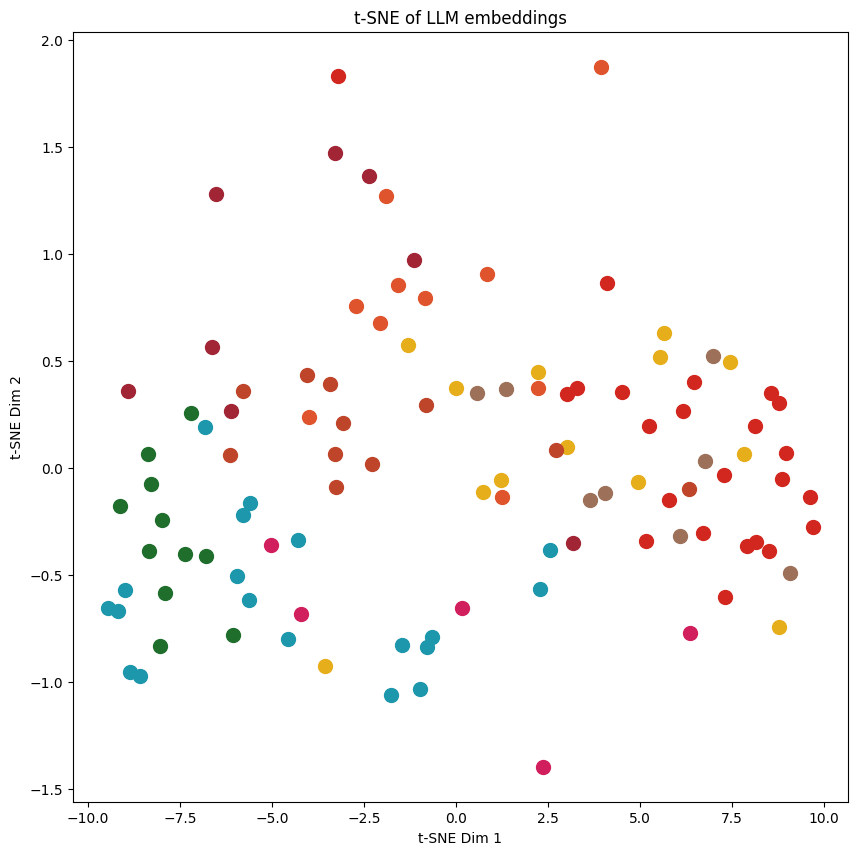

In [15]:
# finetuned GPT
if gpt_embeddings['finetuned'] is not None:
    plot_relative_embeddings(gpt_embeddings['finetuned'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Finetuned_GPT')

Save as file: Pretrained_RoBERTa.png successfully.


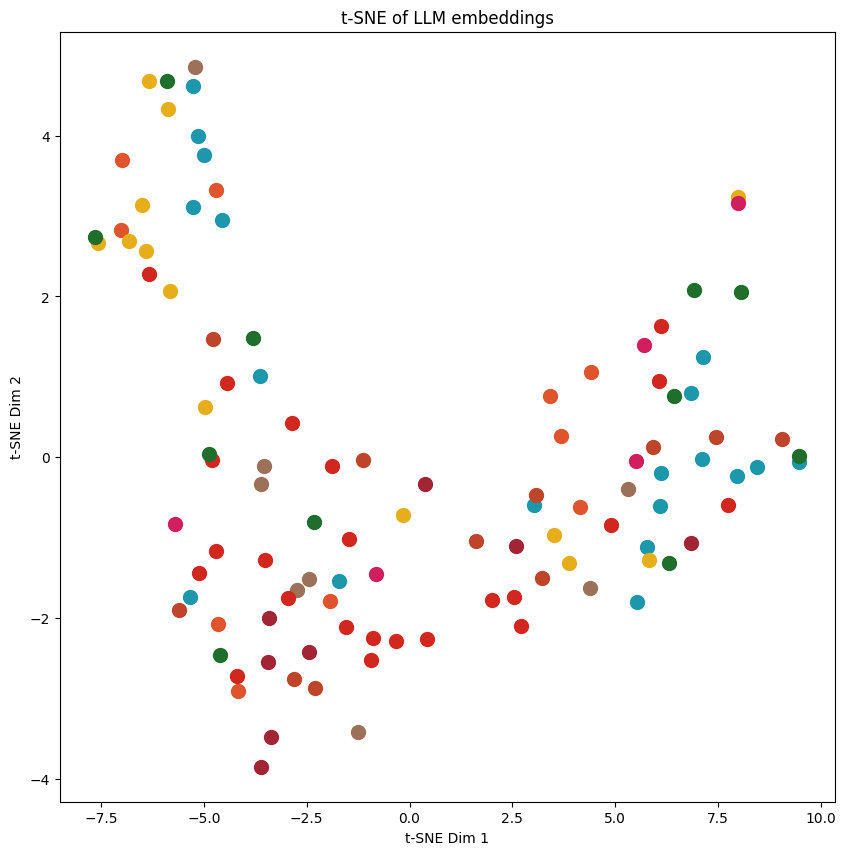

In [16]:
# pretained RoBERTa
if roberta_embeddings['pretrained'] is not None:
    plot_relative_embeddings(roberta_embeddings['pretrained'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Pretrained_RoBERTa')

Save as file: Finetuned_RoBERTa.png successfully.


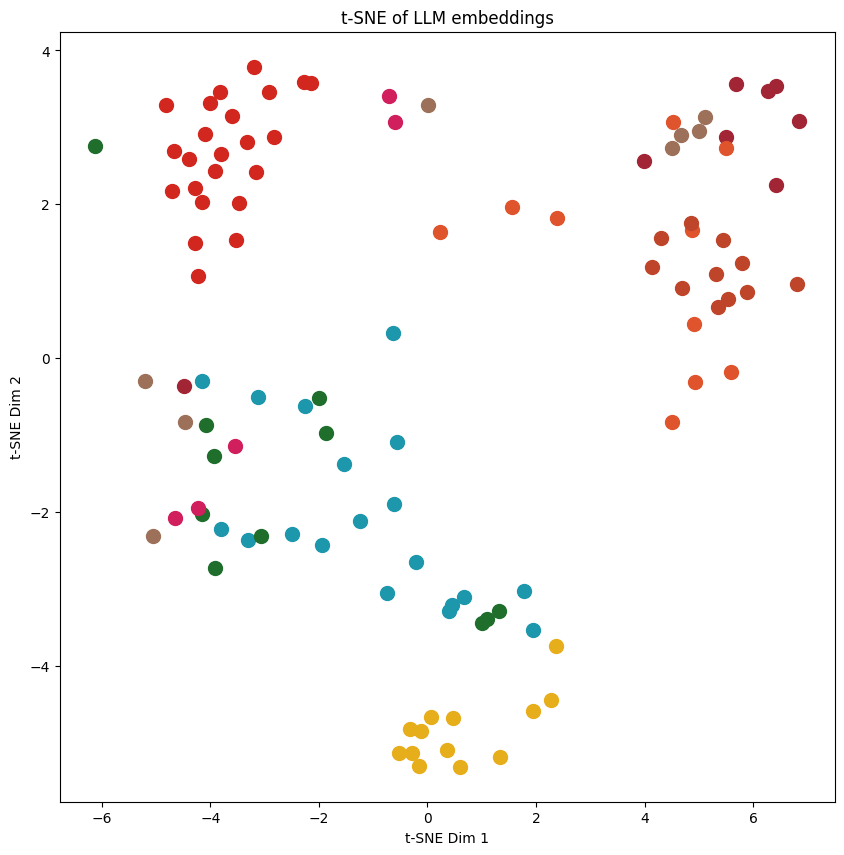

In [17]:
# finetuned RoBERTa
if roberta_embeddings['finetuned'] is not None:
    plot_relative_embeddings(roberta_embeddings['finetuned'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Finetuned_RoBERTa')

Save as file: Pretrained_T5_enc.png successfully.


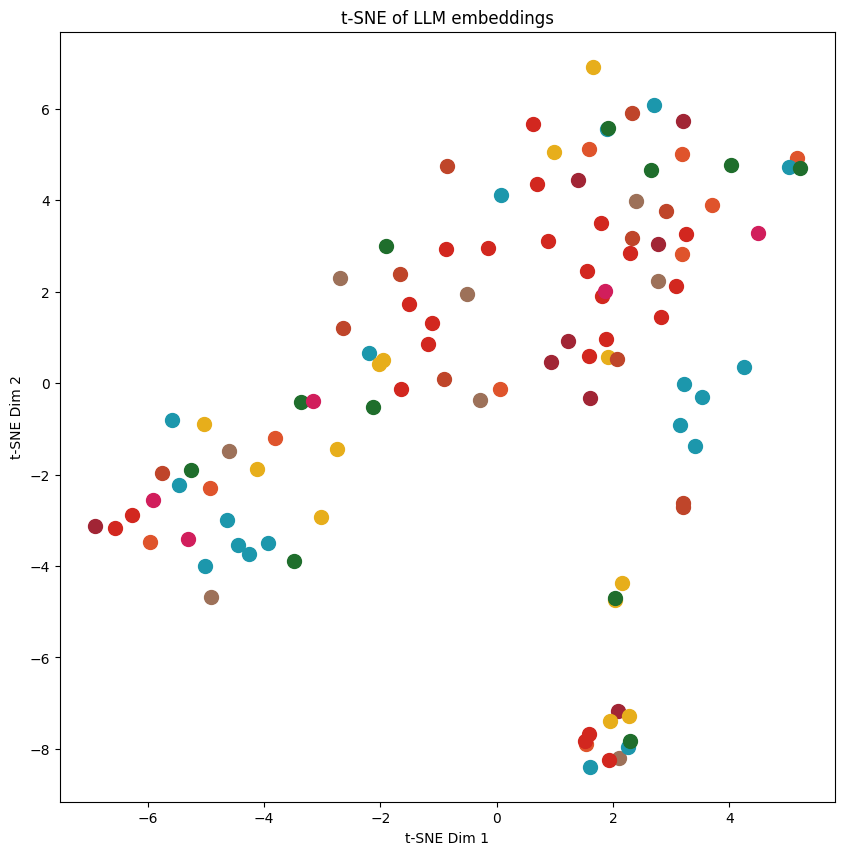

In [18]:
# pretained T5 encoder
if t5_embeddings['pretrained'] is not None:
    plot_relative_embeddings(t5_embeddings['pretrained'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Pretrained_T5_enc')

Save as file: Finetuned_T5_enc.png successfully.


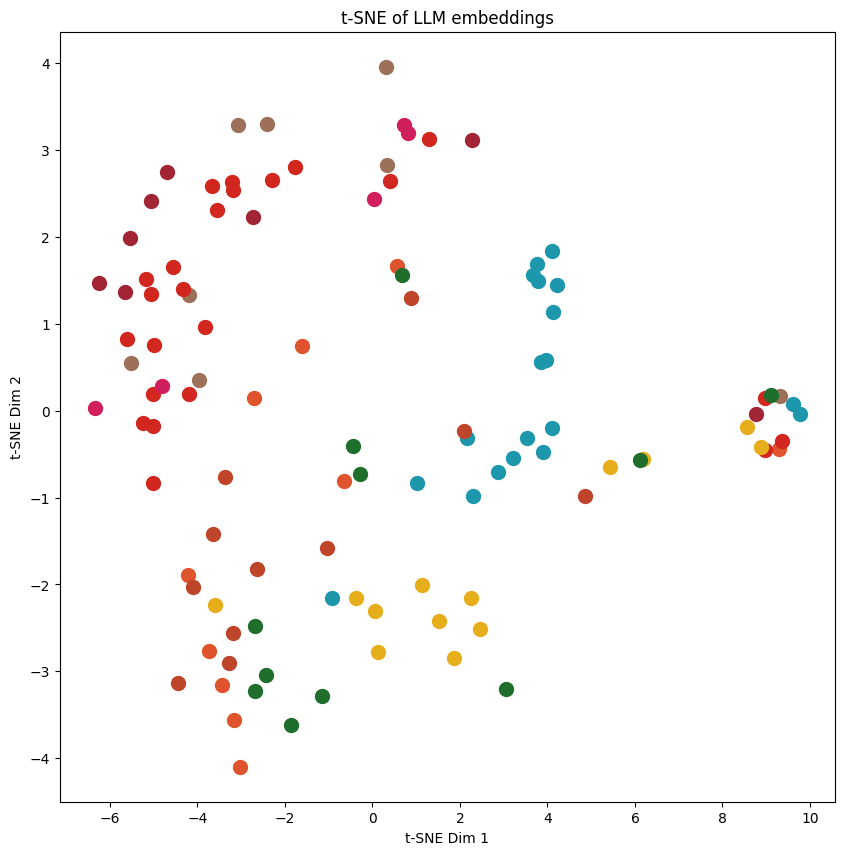

In [19]:
# finetuned T5 encoder
if t5_embeddings['finetuned'] is not None:
    plot_relative_embeddings(t5_embeddings['finetuned'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Finetuned_T5_enc')

Save as file: Pretrained_T5_dec.png successfully.


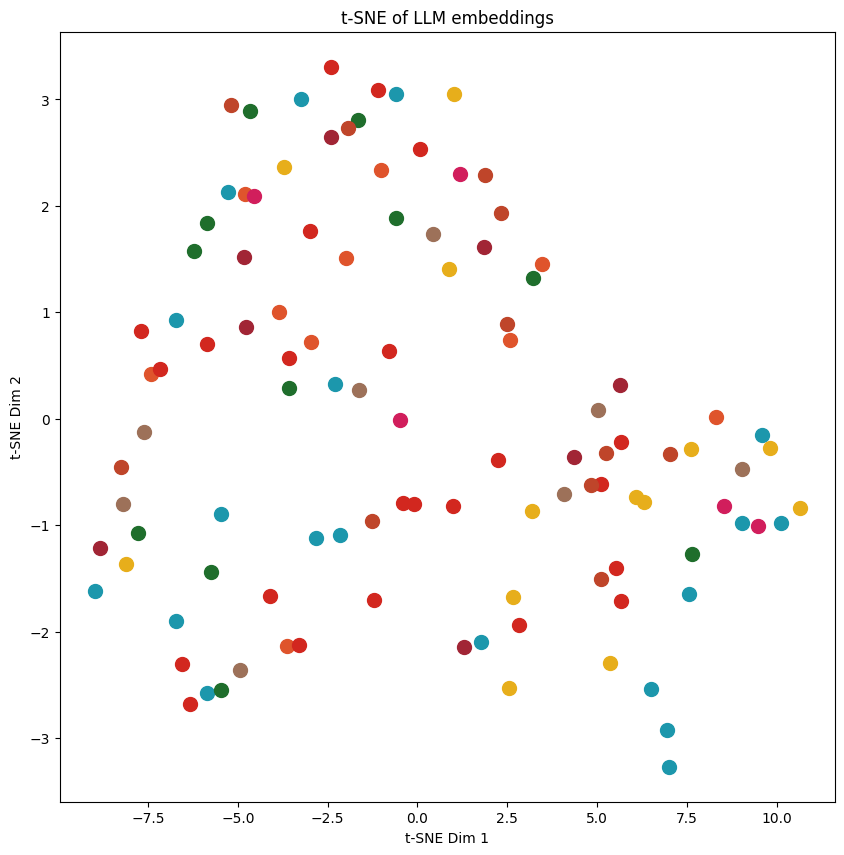

In [20]:
# pretained T5 decoder
if t5_embeddings['pretrained'] is not None:
    plot_relative_embeddings(t5_embeddings['pretrained'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Pretrained_T5_dec')

Save as file: Finetuned_T5_dec.png successfully.


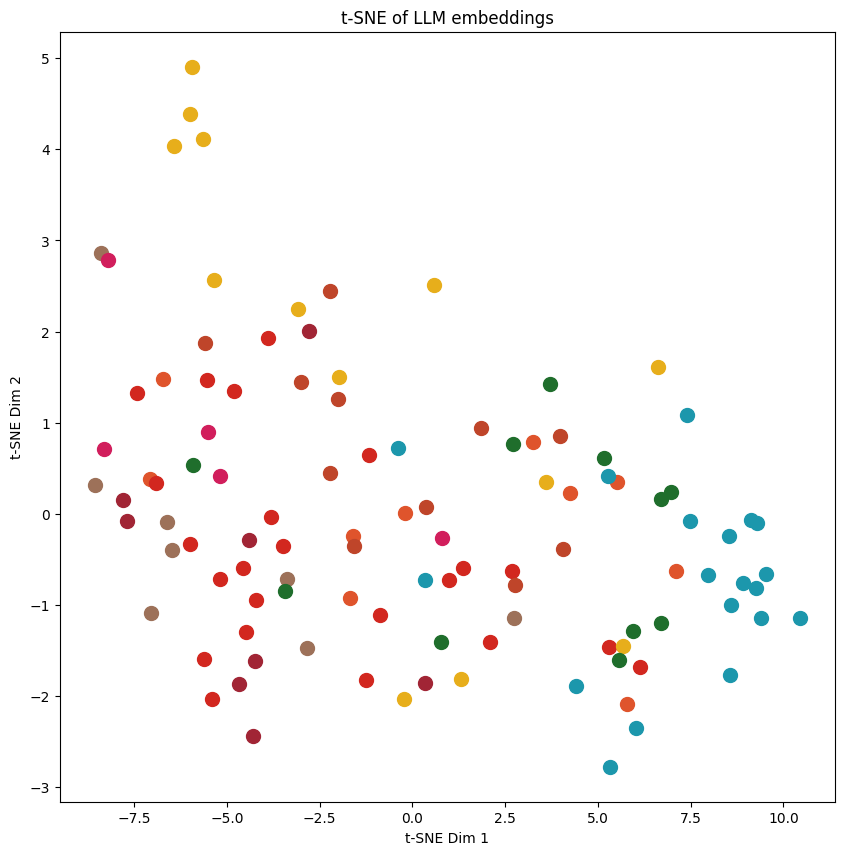

In [21]:
# finetuned T5 decoder
if t5_embeddings['finetuned'] is not None:
    plot_relative_embeddings(t5_embeddings['finetuned'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Finetuned_T5_dec')

Save as file: Pretrained_Gemma2.png successfully.


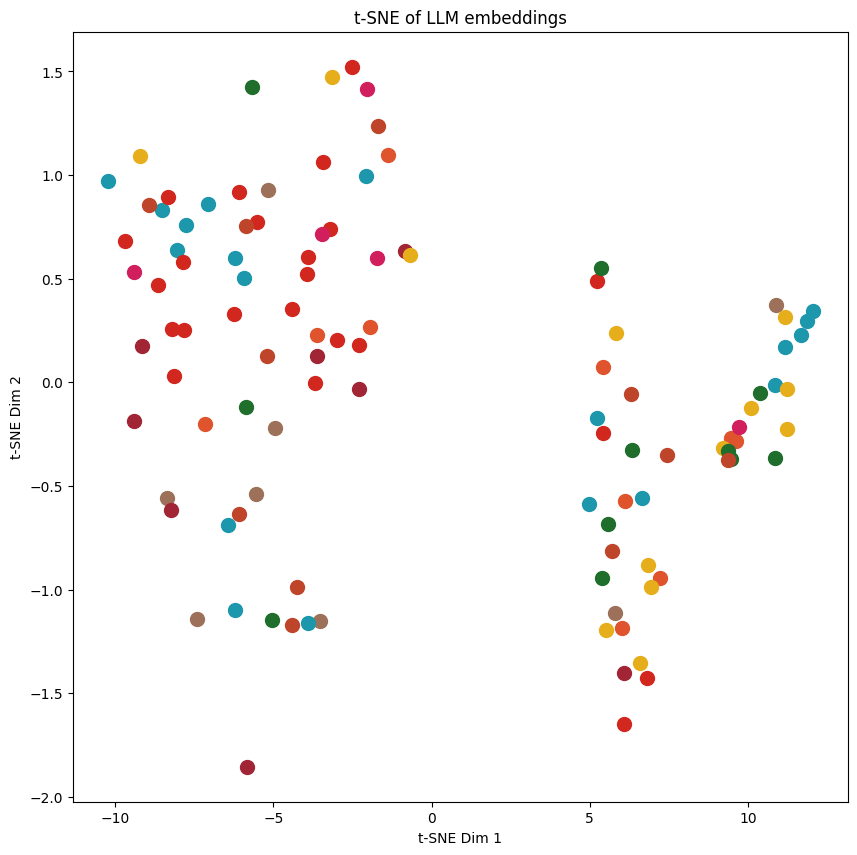

In [22]:
# pretained Gemma2
if gemma2_embeddings['pretrained'] is not None:
    plot_relative_embeddings(gemma2_embeddings['pretrained'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Pretrained_Gemma2')

Save as file: Pretrained_Llama3.png successfully.


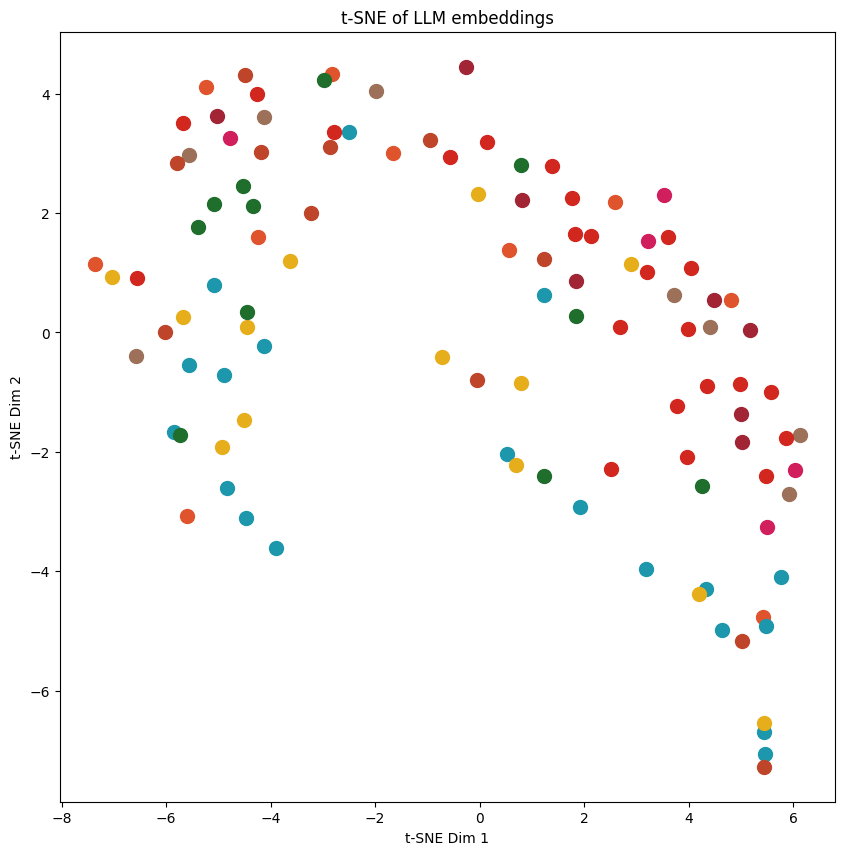

In [23]:
# pretained Llama3
if llama3_embeddings['pretrained'] is not None:
    plot_relative_embeddings(llama3_embeddings['pretrained'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Pretrained_Llama3')

Save as file: Pretrained_Qwen2.png successfully.


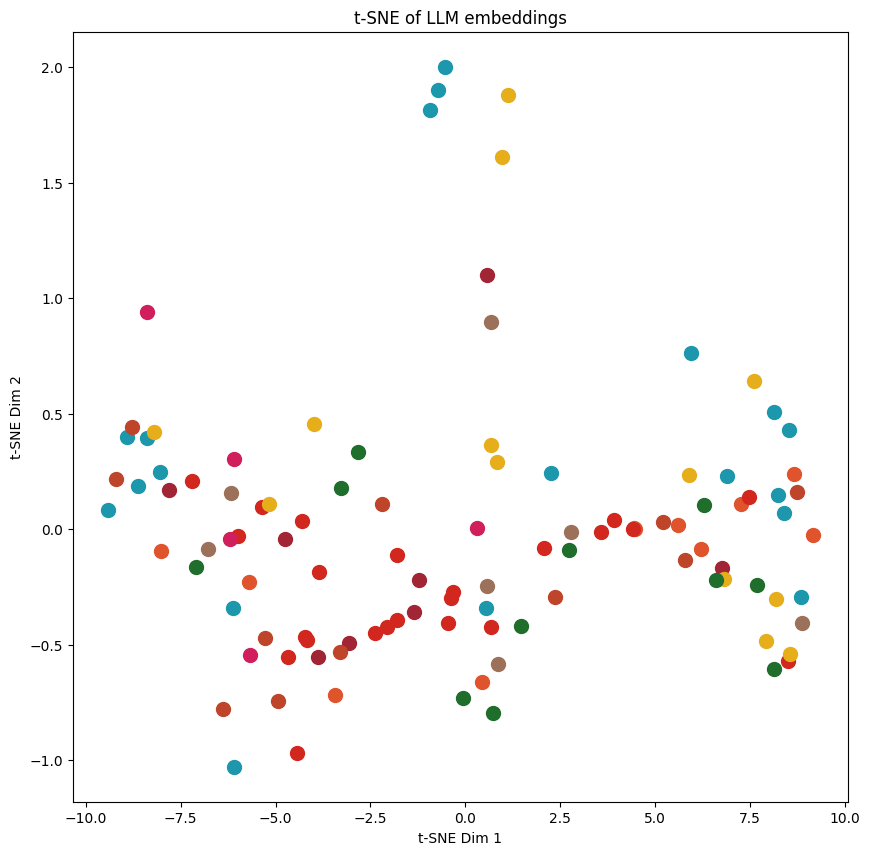

In [24]:
# pretained Qwen2
if qwen2_embeddings['pretrained'] is not None:
    plot_relative_embeddings(qwen2_embeddings['pretrained'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors,
                             filename = 'Pretrained_Qwen2')